In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import pandas_to_fits, fits_to_pandas
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
import healpy as hp
import nway_python_api as nway
%matplotlib inline

This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py


 make a Chandra sample of X-ray sources in LH region

In [3]:
csc_orig = pd.read_pickle(data_path+'/csc_init_df.gz_pkl',compression='gzip')
csc_orig.rename(columns={'name':'name_csc'},inplace=True)
csc_orig_LH = csc_orig.query('(ra > 154.763934) & (ra < 167.084550) & (dec > 54.124219) & (dec < 61.236185)')
csc_orig_LH.rename(columns={'r_98_csc':'pos_err', 'ra': 'RA', 'dec': 'DEC'},inplace=True) 

pandas_to_fits(dataframe = csc_orig_LH[['name_csc', 'RA', 'DEC', 'flux_csc_05_2', 'pos_err']], 
                filename = '/csc_LH.fits',
                table_header_name = 'CHANDRA_LH',
                sky_area_deg2 = 4)


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_67786/4175952757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csc_orig_LH.rename(columns={'r_98_csc':'pos_err', 'ra': 'RA', 'dec': 'DEC'},inplace=True)


In [4]:
ero_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits')
csc_table = nway.table_from_fits(data_path+'csc_LH.fits')
desi_table = nway.table_from_fits(data_path+'desi_lh.fits', poserr_value=0.1)

ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits')
csc_pandas = fits_to_pandas('csc_LH.fits')
desi_pandas = fits_to_pandas('desi_lh.fits')

In [5]:
print(ero_pandas.head(2))
print(csc_pandas.head(2))
print(desi_pandas.head(2))

   EROSITA                        ID          RA        DEC   pos_err  \
0        0  b'SRGe J103744.3+571156'  159.434594  57.198788  1.101567   
1        1  b'SRGe J110137.5+572926'  165.406353  57.490464  1.157204   

      ML_FLUX_0  
0  3.284168e-12  
1  1.969860e-12  
   CHANDRA_LH                  name_csc          RA        DEC  flux_csc_05_2  \
0           0  b'2CXO J103055.3+573319'  157.730445  57.555387   3.936033e-15   
1           1  b'2CXO J103103.2+573648'  157.763336  57.613592   2.395256e-15   

    pos_err  
0  5.106799  
1  2.655115  
   DESI              desi_id          ra        dec     mag_g     mag_r  \
0     0  b'9011_606802_2605'  165.460954  56.382573  2.915254  2.087654   
1     1  b'9011_605177_2992'  157.655218  55.980398  4.877345  4.564330   

      mag_z    mag_w1    mag_w2    col_gr    col_rz   col_zw1   col_rw2  \
0  1.722280  5.013193  5.196579  0.827600  0.365374 -3.290913 -3.108925   
1  4.505185  6.241055  6.745312  0.313015  0.059145 -1.735870 -2

# eROSITAxChandra

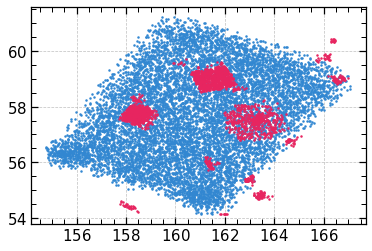

In [6]:
plt.plot(ero_table['ra'], ero_table['dec'], '.')
plt.plot(csc_table['ra'], csc_table['dec'], '.')

## calculate separations with NWAY

In [7]:

nway_res_ero_orig = nway.nwaylib.nway_match(
[ero_table, csc_table],
match_radius = 30,
prior_completeness = 0.7,
)


matching: healpix hashing on pixel resolution ~ 36.072607 arcsec (nside=4096)
100%|██████████| 11829/11829 [00:00<00:00, 20434.97it/s]
matching: collecting from 63376 buckets, creating cartesian products ...
100%|██████████| 63376/63376 [00:00<00:00, 401724.38it/s]
matching:  14776 unique matches from cartesian product. sorting ...
    adding angular separation columns
matching:  10464 matches after filtering by search radius
Primary catalogue "EROSITA" (9500), density gives 2.13e+07 objects on entire sky
Catalogue "CHANDRA_LH" (2329), density gives 2.40e+07 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 9500/9500 [00:06<00:00, 1580.86it/s]

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


In [8]:
nway_res_ero = nway_res_ero_orig.merge(ero_pandas, on='EROSITA', how='left')
nway_res_ero = nway_res_ero.merge(csc_pandas, on='CHANDRA_LH', how='left', suffixes=['_ero', '_csc'])

In [9]:
nway_res_ero = nway_res_ero.sort_values(by = ['EROSITA', 'Separation_EROSITA_CHANDRA_LH'], ascending=[True, True])
nway_res_ero = nway_res_ero[nway_res_ero.CHANDRA_LH!=-1]
nway_res_ero['isin_error'] = nway_res_ero.apply(lambda row: row['Separation_EROSITA_CHANDRA_LH']<row['pos_err_ero'], axis=1)
nway_res_ero

,EROSITA,CHANDRA_LH,Separation_EROSITA_CHANDRA_LH,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,p_single,match_flag,prob_has_match,prob_this_match,ID,RA_ero,DEC_ero,pos_err_ero,ML_FLUX_0,name_csc,RA_csc,DEC_csc,flux_csc_05_2,pos_err_csc,isin_error
4,2,2215,20.639838,20.639838,2,7.814585,7.814585,0.655265,0.655265,1,0.661271,0.973655,b'SRGe J105825.0+564723',164.604366,56.789762,6.277419,1.817511e-12,b'2CXO J105827.1+564734X',164.613011,56.792994,NaN,5.912696,False
3,2,2213,24.090667,24.090667,2,6.246873,6.246873,0.048915,0.048915,0,0.661271,0.026345,b'SRGe J105825.0+564723',164.604366,56.789762,6.277419,1.817511e-12,b'2CXO J105826.0+564700',164.608461,56.783457,1.647693e-14,1.284067,False
33,30,1608,9.432972,9.432972,2,8.832633,8.832633,0.951956,0.951956,1,0.951956,1.000000,b'SRGe J104911.9+575018',162.299749,57.838268,3.623334,3.477559e-13,b'2CXO J104911.9+575008',162.299763,57.835648,5.718070e-14,4.641821,False
40,36,2216,22.736379,22.736379,2,5.841509,5.841509,0.019823,0.019823,1,0.019823,1.000000,b'SRGe J105835.2+564717',164.646843,56.788090,4.788563,2.808731e-13,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,False
45,40,1674,6.535866,6.535866,2,8.755959,8.755959,0.943206,0.943206,1,0.943206,1.000000,b'SRGe J105009.7+570719',162.540215,57.122010,3.827659,2.747705e-13,b'2CXO J105009.2+570724',162.538391,57.123532,0.000000e+00,10.551072,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,9272,787,23.903703,23.903703,2,6.131326,6.131326,0.037921,0.037921,0,0.985729,0.000571,b'SRGe J104353.8+584042',160.974258,58.678243,4.921288,3.098542e-15,b'2CXO J104350.8+584034',160.962038,58.676312,1.472513e-15,3.796640,False
10235,9274,1382,1.225655,1.225655,2,9.320514,9.320514,0.983854,0.983854,1,0.983854,1.000000,b'SRGe J104730.2+584301',161.875925,58.716881,5.961890,3.093352e-15,b'2CXO J104730.0+584301',161.875400,58.717085,4.601460e-15,2.091949,True
10326,9363,1191,4.155011,4.155011,2,9.316910,9.316910,0.983721,0.983721,1,0.983726,0.999704,b'SRGe J104624.2+584333',161.600662,58.725841,5.377918,2.885024e-15,b'2CXO J104624.0+584328',161.600304,58.724701,1.793907e-15,1.464619,True
10325,9363,1184,23.924891,23.924891,2,5.788504,5.788504,0.017585,0.017585,0,0.983726,0.000296,b'SRGe J104624.2+584333',161.600662,58.725841,5.377918,2.885024e-15,b'2CXO J104622.1+584315',161.592238,58.720836,5.548945e-16,2.359937,False


## select secure matches: separation < erosita positional error AND only one CSC source within 20 arcsec

In [10]:
nway_res_ero_unique_match =  nway_res_ero.groupby(by = 'EROSITA', ).agg({'CHANDRA_LH': len})
nway_res_ero_unique_match.rename(columns={'CHANDRA_LH': 'num_chandra_30'}, inplace=True)

In [14]:
nway_res_ero_unique_match.value_counts()

num_chandra_30
1                 681
2                 105
3                  20
4                   2
5                   1
dtype: int64

In [15]:
nway_res_ero = nway_res_ero.merge(nway_res_ero_unique_match, left_on='EROSITA', right_index=True)
nway_res_ero

,EROSITA,CHANDRA_LH,Separation_EROSITA_CHANDRA_LH,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,p_single,match_flag,prob_has_match,prob_this_match,ID,RA_ero,DEC_ero,pos_err_ero,ML_FLUX_0,name_csc,RA_csc,DEC_csc,flux_csc_05_2,pos_err_csc,isin_error,num_chandra_30
4,2,2215,20.639838,20.639838,2,7.814585,7.814585,0.655265,0.655265,1,0.661271,0.973655,b'SRGe J105825.0+564723',164.604366,56.789762,6.277419,1.817511e-12,b'2CXO J105827.1+564734X',164.613011,56.792994,NaN,5.912696,False,2
3,2,2213,24.090667,24.090667,2,6.246873,6.246873,0.048915,0.048915,0,0.661271,0.026345,b'SRGe J105825.0+564723',164.604366,56.789762,6.277419,1.817511e-12,b'2CXO J105826.0+564700',164.608461,56.783457,1.647693e-14,1.284067,False,2
33,30,1608,9.432972,9.432972,2,8.832633,8.832633,0.951956,0.951956,1,0.951956,1.000000,b'SRGe J104911.9+575018',162.299749,57.838268,3.623334,3.477559e-13,b'2CXO J104911.9+575008',162.299763,57.835648,5.718070e-14,4.641821,False,1
40,36,2216,22.736379,22.736379,2,5.841509,5.841509,0.019823,0.019823,1,0.019823,1.000000,b'SRGe J105835.2+564717',164.646843,56.788090,4.788563,2.808731e-13,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,False,1
45,40,1674,6.535866,6.535866,2,8.755959,8.755959,0.943206,0.943206,1,0.943206,1.000000,b'SRGe J105009.7+570719',162.540215,57.122010,3.827659,2.747705e-13,b'2CXO J105009.2+570724',162.538391,57.123532,0.000000e+00,10.551072,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,9272,787,23.903703,23.903703,2,6.131326,6.131326,0.037921,0.037921,0,0.985729,0.000571,b'SRGe J104353.8+584042',160.974258,58.678243,4.921288,3.098542e-15,b'2CXO J104350.8+584034',160.962038,58.676312,1.472513e-15,3.796640,False,3
10235,9274,1382,1.225655,1.225655,2,9.320514,9.320514,0.983854,0.983854,1,0.983854,1.000000,b'SRGe J104730.2+584301',161.875925,58.716881,5.961890,3.093352e-15,b'2CXO J104730.0+584301',161.875400,58.717085,4.601460e-15,2.091949,True,1
10326,9363,1191,4.155011,4.155011,2,9.316910,9.316910,0.983721,0.983721,1,0.983726,0.999704,b'SRGe J104624.2+584333',161.600662,58.725841,5.377918,2.885024e-15,b'2CXO J104624.0+584328',161.600304,58.724701,1.793907e-15,1.464619,True,2
10325,9363,1184,23.924891,23.924891,2,5.788504,5.788504,0.017585,0.017585,0,0.983726,0.000296,b'SRGe J104624.2+584333',161.600662,58.725841,5.377918,2.885024e-15,b'2CXO J104622.1+584315',161.592238,58.720836,5.548945e-16,2.359937,False,2


In [20]:
nway_res_ero_secure_match = nway_res_ero.query('num_chandra_30==1')
nway_res_ero_secure_match.drop_duplicates(subset='name_csc', inplace=True, keep = False)
nway_res_ero_secure_match

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_67786/1831925973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nway_res_ero_secure_match.drop_duplicates(subset='name_csc', inplace=True, keep = False)


,EROSITA,CHANDRA_LH,Separation_EROSITA_CHANDRA_LH,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,p_single,match_flag,prob_has_match,prob_this_match,ID,RA_ero,DEC_ero,pos_err_ero,ML_FLUX_0,name_csc,RA_csc,DEC_csc,flux_csc_05_2,pos_err_csc,isin_error,num_chandra_30
40,36,2216,22.736379,22.736379,2,5.841509,5.841509,0.019823,0.019823,1,0.019823,1.0,b'SRGe J105835.2+564717',164.646843,56.788090,4.788563,2.808731e-13,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,False,1
45,40,1674,6.535866,6.535866,2,8.755959,8.755959,0.943206,0.943206,1,0.943206,1.0,b'SRGe J105009.7+570719',162.540215,57.122010,3.827659,2.747705e-13,b'2CXO J105009.2+570724',162.538391,57.123532,0.000000e+00,10.551072,False,1
73,67,2230,2.779278,2.779278,2,9.407235,9.407235,0.986738,0.986738,1,0.986738,1.0,b'SRGe J110242.6+594120',165.677384,59.688978,4.130682,1.846204e-13,b'2CXO J110242.8+594122',165.678600,59.689447,2.196054e-13,3.481875,True,1
85,77,1954,0.970884,0.970884,2,10.405366,10.405366,0.998652,0.998652,1,0.998652,1.0,b'SRGe J105316.7+573551',163.319421,57.597379,1.228458,1.725409e-13,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,True,1
91,82,1919,1.147400,1.147400,2,10.370487,10.370487,0.998539,0.998539,1,0.998539,1.0,b'SRGe J105300.9+574208',163.253903,57.702143,1.232803,1.645794e-13,b'2CXO J105301.0+574208',163.254465,57.702249,NaN,1.168988,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10159,9206,768,2.495724,2.495724,2,9.352754,9.352754,0.984992,0.984992,1,0.984992,1.0,b'SRGe J104341.0+590023',160.920944,59.006447,5.577126,3.201455e-15,b'2CXO J104341.2+590021',160.921860,59.005939,1.203987e-15,1.845178,True,1
10173,9219,426,5.400560,5.400560,2,9.028554,9.028554,0.968857,0.968857,1,0.968857,1.0,b'SRGe J103413.7+581151',158.557276,58.197420,6.659873,3.185397e-15,b'2CXO J103413.0+581151',158.554454,58.197617,2.721475e-15,4.349873,True,1
10226,9269,461,3.250830,3.250830,2,9.343983,9.343983,0.984690,0.984690,1,0.984690,1.0,b'SRGe J103429.8+575220',158.624361,57.872160,5.579887,3.104600e-15,b'2CXO J103429.6+575217',158.623432,57.871404,6.410410e-15,1.292394,True,1
10235,9274,1382,1.225655,1.225655,2,9.320514,9.320514,0.983854,0.983854,1,0.983854,1.0,b'SRGe J104730.2+584301',161.875925,58.716881,5.961890,3.093352e-15,b'2CXO J104730.0+584301',161.875400,58.717085,4.601460e-15,2.091949,True,1


## save CSC coordinates and positional error to file

In [21]:
csc_companions = nway_res_ero_secure_match[['CHANDRA_LH', 'name_csc', 'RA_csc', 'DEC_csc', 'flux_csc_05_2', 'pos_err_csc']]
csc_companions.rename(columns={'RA_csc': 'RA', 'DEC_csc': 'DEC', 'pos_err_csc': 'pos_err'}, inplace=True)

pandas_to_fits(csc_companions, 'csc_LH_ero_companions_tmp.fits', table_header_name='csc_ero_LH_companions', sky_area_deg2=2)

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_67786/777605523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csc_companions.rename(columns={'RA_csc': 'RA', 'DEC_csc': 'DEC', 'pos_err_csc': 'pos_err'}, inplace=True)


# CSC vs. DESI in LH region

In [22]:
csc_ctps_table = nway.table_from_fits(data_path+'csc_LH_ero_companions_tmp.fits')
csc_ctps_pandas = fits_to_pandas('csc_LH_ero_companions_tmp.fits')

## NWAY cross-match (distance only)

In [24]:

nway_csc_desi_orig = nway.nwaylib.nway_match(
[csc_ctps_table, desi_table],
match_radius = 50,
prior_completeness = 0.9,
)


matching: healpix hashing on pixel resolution ~ 72.145215 arcsec (nside=2048)
100%|██████████| 2419237/2419237 [00:06<00:00, 355082.75it/s]
matching: collecting from 3188 buckets, creating cartesian products ...
100%|██████████| 3188/3188 [00:00<00:00, 6928.72it/s]
matching: 818092 unique matches from cartesian product. sorting ...
    adding angular separation columns
matching:  26406 matches after filtering by search radius
Primary catalogue "CSC_ERO_LH_COMPANIONS" (663), density gives 1.37e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 663/663 [00:00<00:00, 2052.19it/s]

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


In [25]:
nway_csc_desi = nway_csc_desi_orig.merge(csc_ctps_pandas, on='CSC_ERO_LH_COMPANIONS', how='left')
nway_csc_desi = nway_csc_desi.merge(desi_pandas, on='DESI', how='left', suffixes=['_csc', '_desi'])
desi_csc = nway_csc_desi
desi_csc.head(6)

,CSC_ERO_LH_COMPANIONS,DESI,Separation_CSC_ERO_LH_COMPANIONS_DESI,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,p_single,match_flag,prob_has_match,prob_this_match,CHANDRA_LH,name_csc,RA,DEC,flux_csc_05_2,pos_err,desi_id,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2,col_gr,col_rz,col_zw1,col_rw2,nnprior
0,0,-1,NaN,0.000000,1,0.000000,0.000000,1.000000e+00,1.000000e+00,0,0.516593,0.000000e+00,2216,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,23794,34.029867,34.029867,2,-20.230395,-20.230395,2.214457e-30,2.214457e-30,0,0.516593,2.072196e-30,2216,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,b'9011_607597_658',164.635601,56.799773,17.796680,16.673840,15.920493,15.931997,16.371910,1.122840,0.753347,-0.011504,0.301930,0.890592
2,0,27349,16.354345,16.354345,2,3.025528,3.025528,3.991990e-07,3.991990e-07,0,0.516593,3.735538e-07,2216,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,b'9011_607597_710',164.641264,56.793860,18.115679,17.694847,17.551876,19.049725,19.819921,0.420832,0.142971,-1.497849,-2.125074,0.017103
3,0,29213,12.079779,12.079779,2,6.199468,6.199468,5.954853e-04,5.954853e-04,0,0.516593,5.575622e-04,2216,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,b'9011_607597_633',164.633526,56.787268,18.257107,17.153564,16.412273,16.468498,16.906637,1.103543,0.741291,-0.056225,0.246927,0.816097
4,0,33090,5.905021,5.905021,2,9.099430,9.099430,3.212295e-01,3.212295e-01,2,0.516593,4.428494e-01,2216,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,b'9011_607597_638',164.633764,56.789270,18.533068,17.524343,16.841333,17.041105,17.482214,1.008725,0.683010,-0.199772,0.042129,0.630189
5,0,52376,32.806393,32.806393,2,-18.095023,-18.095023,3.024400e-28,3.024400e-28,0,0.516593,2.830107e-28,2216,b'2CXO J105832.6+564725',164.636058,56.790324,2.394341e-15,2.881923,b'9011_607597_508',164.621678,56.794909,19.478409,19.154238,19.078010,19.556341,20.124107,0.324171,0.076228,-0.478331,-0.969869,0.117528


## search companions within r_false

In [26]:
def annuli_area_deg2(r_in_arcsec, r_out_arcsec):
    r_in_deg = r_in_arcsec/3600
    r_out_deg = r_out_arcsec/3600
    area = np.pi*(r_out_deg**2 - r_in_deg**2)
    return area

def r_false(desi_rho_deg2, thresh = 0.03):
    ''' Belvedersky+ 2022 '''
    desi_rho_arcsec2 = desi_rho_deg2/(3600**2)
    return np.sqrt(-np.log(1-thresh)/(np.pi*desi_rho_arcsec2))


csc = pd.DataFrame(desi_csc.groupby(by = 'name_csc', ).agg({'RA': np.mean, 'DEC': np.mean}))

#calculate total number of DESI sources withing 50'' of each CSC source
csc['desi_tot'] = desi_csc.groupby(by = 'name_csc', ).agg({'Separation_CSC_ERO_LH_COMPANIONS_DESI': ['count']})

#calculate total number of DESI sources withing 0-10-50 arcsec of each CSC source
csc[['desi_sep_10_50']] =  desi_csc.groupby(by = ['name_csc', pd.cut(desi_csc.Separation_CSC_ERO_LH_COMPANIONS_DESI, [10, 50]) ]).size().unstack()



#calculate source densities for 0-50'' annulus and 10-50'' annulus
csc['src_dens_deg2'] = csc['desi_tot']/annuli_area_deg2(0, 50)
csc['src_dens_deg2_sep_10_50'] = csc['desi_sep_10_50']/annuli_area_deg2(10, 50)

#drop sources with  zeros in the 10-50'' source density 
print('dropping X-ray sources with zero in the 10-50'' source density,', len(csc[csc.src_dens_deg2_sep_10_50 == 0]), ' sources')
csc.drop(csc[csc.src_dens_deg2_sep_10_50 == 0].index, inplace=True)


#assign r_false for 10-50'' annulus density
csc['r_false_003_dens_deg2_sep_10_50'] = r_false(csc['src_dens_deg2_sep_10_50'])

csc.reset_index(inplace=True)

#assign r_false for each CSC source from csc dataframe to desi_csc dataframe
desi_csc = desi_csc.merge(csc[['name_csc','r_false_003_dens_deg2_sep_10_50']], on='name_csc')


dropping X-ray sources with zero in the 10-50 source density, 0  sources


count    663.000000
mean       1.457169
std        0.199470
min        0.911431
25%        1.319290
50%        1.445210
75%        1.561005
max        2.577915
Name: r_false_003_dens_deg2_sep_10_50, dtype: float64

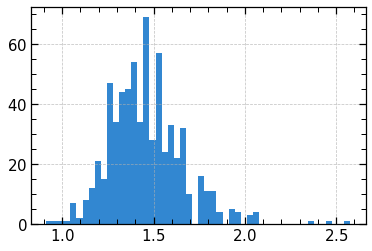

In [27]:
plt.hist(csc.r_false_003_dens_deg2_sep_10_50, bins = 50)
csc.r_false_003_dens_deg2_sep_10_50.describe()

In [28]:
#column whether sep_csc < r_98_csc
desi_csc['sep_csc_less_r_false_003_dens_deg2_sep_10_50'] = desi_csc.Separation_CSC_ERO_LH_COMPANIONS_DESI < desi_csc.pos_err

#column whether sep_csc < r_false
desi_csc['sep_csc_less_r_false'] = desi_csc.Separation_CSC_ERO_LH_COMPANIONS_DESI < desi_csc.r_false_003_dens_deg2_sep_10_50



#calculate for each CSC source the number of DESI sources within r_false
tmp_df = pd.DataFrame(desi_csc.query('Separation_CSC_ERO_LH_COMPANIONS_DESI <= r_false_003_dens_deg2_sep_10_50').groupby(by = 'name_csc').Separation_CSC_ERO_LH_COMPANIONS_DESI.apply('count'))
print(tmp_df.Separation_CSC_ERO_LH_COMPANIONS_DESI.value_counts())
tmp_df.columns = ['r_false_003_dens_deg2_sep_10_50']


#merge with desi_csc dataframe
desi_csc = desi_csc.merge(tmp_df, on='name_csc')
desi_csc.head(10)

1    484
2     18
Name: Separation_CSC_ERO_LH_COMPANIONS_DESI, dtype: int64


,CSC_ERO_LH_COMPANIONS,DESI,Separation_CSC_ERO_LH_COMPANIONS_DESI,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,p_single,match_flag,prob_has_match,prob_this_match,CHANDRA_LH,name_csc,RA,DEC,flux_csc_05_2,pos_err,desi_id,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2,col_gr,col_rz,col_zw1,col_rw2,nnprior,r_false_003_dens_deg2_sep_10_50_x,sep_csc_less_r_false_003_dens_deg2_sep_10_50,sep_csc_less_r_false,r_false_003_dens_deg2_sep_10_50_y
0,3,-1,NaN,0.000000,1,0.000000,0.000000,1.000000e+00,1.000000e+00,0,0.959801,0.000000e+00,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.535621,False,False,1
1,3,42150,0.144735,0.144735,2,10.801307,10.801307,9.597123e-01,9.597123e-01,1,0.959801,9.976974e-01,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3809',163.319852,57.597425,19.056164,18.587671,18.529188,17.950235,17.488895,0.468493,0.058483,0.578953,1.098776,0.974126,1.535621,True,True,1
2,3,58181,26.166657,26.166657,2,-100.647200,-100.647200,8.481288e-111,8.481288e-111,0,0.959801,3.552152e-112,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3837',163.323956,57.604390,19.690811,19.366983,19.325523,20.536602,21.659752,0.323828,0.041460,-1.211079,-2.292769,0.005561,1.535621,False,False,1
3,3,214883,27.812277,27.812277,2,-115.106425,-115.106425,2.946026e-125,2.946026e-125,0,0.959801,1.233861e-126,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3711',163.306547,57.594547,21.754690,20.911120,20.399790,20.707058,22.708742,0.843570,0.511330,-0.307268,-1.797622,0.002238,1.535621,False,False,1
4,3,355197,41.097826,41.097826,2,-264.129482,-264.129482,2.793701e-274,2.793701e-274,0,0.959801,1.170064e-275,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3954',163.340485,57.594502,22.410658,21.630783,20.152166,18.647816,19.145891,0.779875,1.478617,1.504350,2.484892,0.726702,1.535621,False,False,1
5,3,590639,43.571648,43.571648,2,-298.224150,-298.224150,2.246529e-308,2.246529e-308,0,0.959801,9.408962e-310,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3758',163.311177,57.608616,23.014524,22.409150,21.446983,20.605219,21.311064,0.605374,0.962167,0.841764,1.098086,0.113535,1.535621,False,False,1
6,3,613818,38.612212,38.612212,2,-231.878886,-231.878886,4.974809e-242,4.974809e-242,0,0.959801,2.083561e-243,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3816',163.320966,57.608163,23.057598,22.905780,22.862158,21.233355,21.324217,0.151818,0.043622,1.628803,1.581563,0.444450,1.535621,False,False,1
7,3,625823,22.972554,22.972554,2,-75.098544,-75.098544,2.999975e-85,2.999975e-85,0,0.959801,1.256456e-86,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3798',163.317529,57.591200,23.080322,22.937437,22.121733,22.193216,NaN,0.142885,0.815704,-0.071483,NaN,0.107959,1.535621,False,False,1
8,3,665698,47.507605,47.507605,2,-356.576844,-356.576844,0.000000e+00,0.000000e+00,0,0.959801,0.000000e+00,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3773',163.313041,57.584779,23.148458,22.082392,21.366707,20.650902,20.640888,1.066066,0.715685,0.715805,1.441504,0.186508,1.535621,False,False,1
9,3,814337,49.753651,49.753651,2,-392.135838,-392.135838,0.000000e+00,0.000000e+00,0,0.959801,0.000000e+00,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3928',163.337219,57.587210,23.364782,23.348385,22.052322,20.867071,21.125002,0.016397,1.296063,1.185251,2.223383,0.242062,1.535621,False,False,1


In [34]:
def counterpart_quality_flag(row):
    if   row.sep_csc_less_r_false and row.r_false_003_dens_deg2_sep_10_50_y==1:
        return 1
    elif   row.sep_csc_less_r_false and row.r_false_003_dens_deg2_sep_10_50_y==1:
        sreturn 2
    else:
        return 0

desi_csc['counterpart_quality_flag'] = desi_csc.apply(counterpart_quality_flag, axis=1)

In [35]:
print('counterparts by flag:')
desi_csc['counterpart_quality_flag'].value_counts()

counterparts by flag:


0    19107
1      484
Name: counterpart_quality_flag, dtype: int64

In [37]:
desi_csc[~desi_csc.flux_csc_05_2.isna()]['counterpart_quality_flag'].value_counts()

0    16130
1      412
Name: counterpart_quality_flag, dtype: int64

In [ ]:
sssss

In [ ]:
desi_csc_ctps = desi_csc[desi_csc.counterpart_quality_flag != 0]


In [ ]:
desi_csc_ctps

,CSC_ERO_LH_COMPANIONS,DESI,Separation_CSC_ERO_LH_COMPANIONS_DESI,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,p_single,match_flag,prob_has_match,prob_this_match,CHANDRA_LH,name_csc,RA,DEC,flux_csc_05_2,pos_err,desi_id,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2,col_gr,col_rz,col_zw1,col_rw2,nnprior,r_false_003_dens_deg2_sep_10_50,sep_csc_less_r_98,sep_csc_less_r_false,total_sep_csc_less_r_98,counterpart_quality_flag
1,1,42150,0.144735,0.144735,2,10.801307,10.801307,0.959712,0.959712,1,0.959801,0.997697,1954,b'2CXO J105316.7+573550',163.319906,57.597453,NaN,1.150662,b'9011_609950_3809',163.319852,57.597425,19.056164,18.587671,18.529188,17.950235,17.488895,0.468493,0.058483,0.578953,1.098776,0.974126,1.535621,True,True,1,1
75,3,52857,0.649900,0.649900,2,10.707726,10.707726,0.950504,0.950504,1,0.950505,0.999985,1081,b'2CXO J104540.1+584255',161.417276,58.715315,7.112189e-14,1.195988,b'9011_613768_963',161.417162,58.715145,19.508944,19.168417,18.617899,17.700090,17.469213,0.340527,0.550518,0.917809,1.699204,0.971472,1.488360,True,True,1,1
112,4,80809,0.241237,0.241237,2,10.774959,10.774959,0.957300,0.957300,1,0.957338,0.999082,1997,b'2CXO J105335.0+572541',163.395863,57.428329,NaN,1.178657,b'9011_609951_491',163.395958,57.428372,20.276752,20.189299,20.074448,18.821370,18.592844,0.087453,0.114851,1.253078,1.596455,0.943436,1.615794,True,True,1,1
144,5,75936,0.120780,0.120780,2,10.785295,10.785295,0.958262,0.958262,1,0.958287,0.999386,95,b'2CXO J103215.8+574926',158.066135,57.823957,7.892667e-14,1.173765,b'9011_610714_4134',158.066197,57.823954,20.173912,20.245556,19.935146,19.025837,18.631610,-0.071644,0.310410,0.909309,1.613946,0.957802,1.234083,True,True,1,1
202,6,100106,0.074651,0.074651,2,10.801412,10.801412,0.959722,0.959722,1,0.959775,0.998629,1033,b'2CXO J104523.0+555716',161.346047,55.954573,3.557003e-14,1.153874,b'9011_605186_562',161.346014,55.954564,20.632532,19.647840,19.070026,17.427935,17.461353,0.984692,0.577814,1.642091,2.186487,0.955879,1.185668,True,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14306,441,256345,0.827715,0.827715,2,9.644839,9.644839,0.624272,0.624272,1,0.756439,0.534978,426,b'2CXO J103413.0+581151',158.554454,58.197617,2.721475e-15,4.349873,b'9011_612249_2337',158.554890,58.197631,21.999243,21.858717,21.822960,21.969334,20.898317,0.140526,0.035757,-0.146374,0.960400,0.504340,1.405607,True,True,1,1
14352,442,559412,0.380314,0.380314,2,10.775865,10.775865,0.957385,0.957385,1,0.958759,0.966379,1157,b'2CXO J104613.4+585941',161.556158,58.994888,7.356832e-15,1.158174,b'9011_614516_2658',161.556353,58.994856,22.952593,22.669544,22.674606,20.914358,20.161130,0.283049,-0.005062,1.760248,2.508414,0.691194,1.424996,True,True,1,1
14390,443,279197,0.171050,0.171050,2,10.700717,10.700717,0.949740,0.949740,1,0.949740,1.000000,461,b'2CXO J103429.6+575217',158.623432,57.871404,6.410410e-15,1.292394,b'9011_610716_580',158.623347,57.871418,22.111696,21.765709,21.239985,19.822529,19.744299,0.345987,0.525724,1.417456,2.021410,0.788814,1.587691,True,True,1,1
14443,444,1386910,0.454534,0.454534,2,9.921598,9.921598,0.758594,0.758594,1,0.759288,0.996214,796,b'2CXO J104353.9+584043',160.974710,58.678678,2.640598e-15,3.174696,b'9011_613767_1258',160.974716,58.678552,23.950676,23.530556,23.100512,21.286343,20.801338,0.420120,0.430044,1.814169,2.729218,0.408840,1.247142,True,True,1,1


In [ ]:
final_ctps_ero_csc_desi = desi_csc_ctps[['name_csc', 'desi_id']]
final_ctps_ero_csc_desi = final_ctps_ero_csc_desi.merge(nway_res_ero_secure_match[['ID', 'name_csc']], on='name_csc', how='left', suffixes=['_csc', '_ero'])
final_ctps_ero_csc_desi.rename(columns={'ID': 'ID_ero'}, inplace=True)
#final_ctps_ero_csc_desi.to_pickle(data_path+'final_ctps_ero_csc_desi.pkl')
final_ctps_ero_csc_desi



,name_csc,desi_id,ID_ero
0,b'2CXO J105316.7+573550',b'9011_609950_3809',b'SRGe J105316.7+573551'
1,b'2CXO J104540.1+584255',b'9011_613768_963',b'SRGe J104540.1+584254'
2,b'2CXO J105335.0+572541',b'9011_609951_491',b'SRGe J105335.1+572543'
3,b'2CXO J103215.8+574926',b'9011_610714_4134',b'SRGe J103216.0+574927'
4,b'2CXO J104523.0+555716',b'9011_605186_562',b'SRGe J104523.1+555715'
...,...,...,...
347,b'2CXO J103413.0+581151',b'9011_612249_2337',b'SRGe J103413.7+581151'
348,b'2CXO J104613.4+585941',b'9011_614516_2658',b'SRGe J104614.0+585942'
349,b'2CXO J103429.6+575217',b'9011_610716_580',b'SRGe J103429.8+575220'
350,b'2CXO J104353.9+584043',b'9011_613767_1258',b'SRGe J104353.8+584042'
